In [1]:
# importações necessárias para o algoritmo
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
input_path = '../data/CE_Crateus.csv'
output_path = '../data/CE_Crateus2.csv'

In [3]:
# transforma a data em formato apropriado
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y %H%M')

In [4]:
# carrega os dados do conjunto de dados de entrada, padroniza e os salva no local desejado
def format_dataset(input_path, output_path):
    dataset = read_csv(input_path,  parse_dates=[['Data', 'Hora']], index_col=0, date_parser=parse)

    dataset.index.name = 'date'
    
    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    # substitui todos os valores NA por 0
    dataset[:].fillna(0, inplace=True)

    # mostra apenas as primeiras 5 linhas
    print(dataset.head(5))

    # salva em arquivo
    dataset.to_csv(output_path)

format_dataset(input_path, output_path)

                     Precipitacao  TempMaxima  TempMinima  Insolacao  \
date                                                                   
2015-01-01 00:00:00           0.0        35.0         0.0        5.9   
2015-01-01 12:00:00           0.0         0.0        23.7        0.0   
2015-01-02 00:00:00           0.0        35.8         0.0       10.6   
2015-01-02 12:00:00           0.0         0.0        23.0        0.0   
2015-01-03 00:00:00           0.0        31.9         0.0        4.3   

                     Evaporacao Piche  Temp Comp Media  \
date                                                     
2015-01-01 00:00:00               0.0            28.76   
2015-01-01 12:00:00               0.0             0.00   
2015-01-02 00:00:00              10.2            26.72   
2015-01-02 12:00:00               0.0             0.00   
2015-01-03 00:00:00               6.2            26.32   

                     Umidade Relativa Media  Velocidade do Vento Media  
date           

In [5]:
# carrega o conjunto de dados
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(output_path)
values = dataset.values

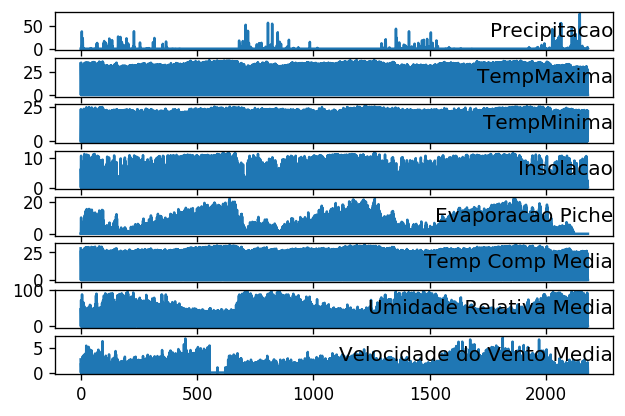

In [6]:
# plota cada coluna como um gráfico
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# converte as series para aprendizagem supervisionada
def series_to_supervised(data, n_x=24, n_y=1):
    n = n_x + 1
    df = DataFrame(data)
    i = 0
    df_len = len(df)
    
    samples = sample = df[0:n]
    df = df.shift(-1)
    df.dropna(inplace=True)
    samples = sample.values
    samples = samples.reshape(1,n,8)

    while(i < df_len-1):
        sample = df[0:n]
        if(sample.size == n*8):
            df = df.shift(-1)
            df.dropna(inplace=True)
            sample = sample.values
            sample = sample.reshape(1,n,8)
            samples = np.concatenate((samples, sample), axis=0)
        else:
            break
        i += 1
        
    return samples

# muda o tipo dos valores para ponto flutuante
values = values.astype('float32')

# normaliza a escala dos dados
scaled = np.log1p(values)

reframed = series_to_supervised(scaled)

reframed.shape

(2157, 25, 8)

In [8]:
# separa o conjunto de dados em subconjuntos de treino e teste
values = reframed
n_train_hours = int(len(reframed) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# separa os subconjuntos de treino e teste em outros subconjuntos
# de entradas e saídas esperadas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1725, 24, 8) (1725, 8) (432, 24, 8) (432, 8)


Train on 1725 samples, validate on 432 samples
Epoch 1/1000
 - 1s - loss: 1.2521 - mean_squared_error: 3.9070 - val_loss: 1.2291 - val_mean_squared_error: 3.8771
Epoch 2/1000
 - 0s - loss: 1.2263 - mean_squared_error: 3.7501 - val_loss: 1.2014 - val_mean_squared_error: 3.6302
Epoch 3/1000
 - 0s - loss: 1.1739 - mean_squared_error: 3.4014 - val_loss: 1.1173 - val_mean_squared_error: 3.1038
Epoch 4/1000
 - 0s - loss: 1.0113 - mean_squared_error: 2.5940 - val_loss: 0.9232 - val_mean_squared_error: 2.1899
Epoch 5/1000
 - 0s - loss: 0.8066 - mean_squared_error: 1.7696 - val_loss: 0.6885 - val_mean_squared_error: 1.4172
Epoch 6/1000
 - 0s - loss: 0.5963 - mean_squared_error: 1.2106 - val_loss: 0.5685 - val_mean_squared_error: 1.1635
Epoch 7/1000
 - 0s - loss: 0.4828 - mean_squared_error: 0.9486 - val_loss: 0.4675 - val_mean_squared_error: 0.9500
Epoch 8/1000
 - 0s - loss: 0.3748 - mean_squared_error: 0.7562 - val_loss: 0.3762 - val_mean_squared_error: 0.8365
Epoch 9/1000
 - 0s - loss: 0.3116

Epoch 72/1000
 - 0s - loss: 0.2287 - mean_squared_error: 0.3338 - val_loss: 0.2814 - val_mean_squared_error: 0.4678
Epoch 73/1000
 - 0s - loss: 0.2273 - mean_squared_error: 0.3297 - val_loss: 0.2800 - val_mean_squared_error: 0.4619
Epoch 74/1000
 - 0s - loss: 0.2263 - mean_squared_error: 0.3252 - val_loss: 0.2791 - val_mean_squared_error: 0.4574
Epoch 75/1000
 - 0s - loss: 0.2249 - mean_squared_error: 0.3197 - val_loss: 0.2777 - val_mean_squared_error: 0.4524
Epoch 76/1000
 - 0s - loss: 0.2238 - mean_squared_error: 0.3164 - val_loss: 0.2762 - val_mean_squared_error: 0.4485
Epoch 77/1000
 - 0s - loss: 0.2222 - mean_squared_error: 0.3114 - val_loss: 0.2749 - val_mean_squared_error: 0.4430
Epoch 78/1000
 - 0s - loss: 0.2210 - mean_squared_error: 0.3072 - val_loss: 0.2740 - val_mean_squared_error: 0.4389
Epoch 79/1000
 - 0s - loss: 0.2198 - mean_squared_error: 0.3020 - val_loss: 0.2725 - val_mean_squared_error: 0.4343
Epoch 80/1000
 - 0s - loss: 0.2184 - mean_squared_error: 0.2984 - val_lo

Epoch 143/1000
 - 0s - loss: 0.1349 - mean_squared_error: 0.1331 - val_loss: 0.1876 - val_mean_squared_error: 0.2621
Epoch 144/1000
 - 0s - loss: 0.1336 - mean_squared_error: 0.1325 - val_loss: 0.1867 - val_mean_squared_error: 0.2594
Epoch 145/1000
 - 0s - loss: 0.1321 - mean_squared_error: 0.1313 - val_loss: 0.1847 - val_mean_squared_error: 0.2594
Epoch 146/1000
 - 0s - loss: 0.1310 - mean_squared_error: 0.1311 - val_loss: 0.1836 - val_mean_squared_error: 0.2579
Epoch 147/1000
 - 0s - loss: 0.1295 - mean_squared_error: 0.1297 - val_loss: 0.1823 - val_mean_squared_error: 0.2583
Epoch 148/1000
 - 0s - loss: 0.1285 - mean_squared_error: 0.1297 - val_loss: 0.1816 - val_mean_squared_error: 0.2571
Epoch 149/1000
 - 0s - loss: 0.1267 - mean_squared_error: 0.1292 - val_loss: 0.1801 - val_mean_squared_error: 0.2559
Epoch 150/1000
 - 0s - loss: 0.1253 - mean_squared_error: 0.1283 - val_loss: 0.1783 - val_mean_squared_error: 0.2556
Epoch 151/1000
 - 0s - loss: 0.1239 - mean_squared_error: 0.1280

 - 0s - loss: 0.0916 - mean_squared_error: 0.1051 - val_loss: 0.1271 - val_mean_squared_error: 0.2006
Epoch 214/1000
 - 0s - loss: 0.0901 - mean_squared_error: 0.1048 - val_loss: 0.1260 - val_mean_squared_error: 0.1994
Epoch 215/1000
 - 0s - loss: 0.0896 - mean_squared_error: 0.1046 - val_loss: 0.1243 - val_mean_squared_error: 0.1982
Epoch 216/1000
 - 0s - loss: 0.0881 - mean_squared_error: 0.1038 - val_loss: 0.1236 - val_mean_squared_error: 0.1983
Epoch 217/1000
 - 0s - loss: 0.0871 - mean_squared_error: 0.1034 - val_loss: 0.1223 - val_mean_squared_error: 0.1982
Epoch 218/1000
 - 0s - loss: 0.0863 - mean_squared_error: 0.1032 - val_loss: 0.1215 - val_mean_squared_error: 0.1976
Epoch 219/1000
 - 0s - loss: 0.0859 - mean_squared_error: 0.1029 - val_loss: 0.1214 - val_mean_squared_error: 0.1974
Epoch 220/1000
 - 0s - loss: 0.0861 - mean_squared_error: 0.1029 - val_loss: 0.1224 - val_mean_squared_error: 0.1975
Epoch 221/1000
 - 0s - loss: 0.0856 - mean_squared_error: 0.1030 - val_loss: 0.

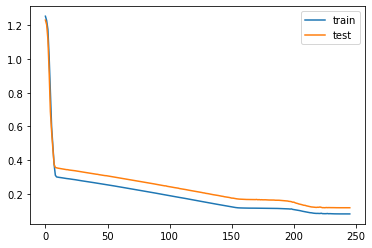

In [9]:
# arquitetura da rede
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16, activation='relu'))   # vale a pena? 
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
]

# modela a rede
history = model.fit(train_X, train_y, 
                    epochs=1000, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=True, 
                    callbacks=callbacks)

# plota em grafico o historico de aprendizado e treino
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
# faz uma predição
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: cannot reshape array of size 82944 into shape (432,24)